In [1]:
from __future__ import division
import numpy as np
import pandas as pd
from skbio.stats.composition import ilr
from skbio import TreeNode
from canvas.phylogeny import phylogenetic_basis
from canvas.viz.ilrtree import balanceplot, balance_test, barchart_layout
from biom import load_table

import random
from ete3 import Tree, TreeStyle, faces, AttrFace, BarChartFace, CircleFace
%matplotlib inline

One way to visualize proportions or counts, is to visualize them as logratios of subtrees in a binary tree.

For an example, we suppose that we have the following tree.

In [2]:
tree = TreeNode.read([u"((a,b), (c,d));"])
print(tree.ascii_art())

                    /-a
          /--------|
         |          \-b
---------|
         |          /-c
          \--------|
                    \-d


In [3]:
table = pd.Series([10, 20, 10, 10],
                  index=['a','b','c','d'])
table

a    10
b    20
c    10
d    10
dtype: int64

Given this data, we can visualize the ratios between the abundances according to this tree.
Here, we will be visualizing the log ratios between a/b, c/d and f/g


In [4]:
basis, nodes = phylogenetic_basis(tree)
ilr_coords = ilr(table, basis=basis)

Now, we can visualize these log-ratios as balances on the tree.  Since the c, d have the same abundances, their ratio is 1, and their log-ratio is zero. So that balance on the c,d subtree is zero.

On the other hand, the abundance of b is double the abundance of a.  So the ratio of a/b is 1/2, making the log ratio -log(2).  So the balance on the a,b subtree is zero. 

The logratios of subtrees can be visualized as balances on the tree as shown below.

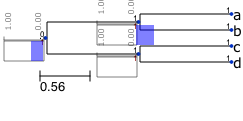

In [5]:
tr, ts = balanceplot(ilr_coords, tree, mode='r', layout=barchart_layout) 
tr.render(file_name='%%inline', tree_style=ts)

In [6]:
table = pd.DataFrame([
            [10, 10, 10, 20, 20, 20],
            [11, 12, 11, 21, 21, 21],
            [10, 11, 10, 10, 11, 10],
            [10, 11, 10, 10, 10, 9],
            [10, 11, 10, 10, 10, 10],
            [10, 11, 10, 10, 10, 11],
            [10, 13, 10, 10, 10, 12]]).T
cats = pd.Series(['Control', 'Control', 'Control', 
                  'Treatment', 'Treatment', 'Treatment'])
tree = TreeNode.read([u"((((((a,b)c, d)e, f)g, h)i, j)k, l);"])
